In [1]:
import numpy as np
from sympy import symbols, Matrix, simplify
import matplotlib.pyplot as plt
from pyscf import gto, scf
from scipy.linalg import fractional_matrix_power
import sys
sys.path.append('/workspaces/bachelor-project-bridging-profile-Mattice-Criel/projects/Project-MatticeCriel/Benzene/rhf')
import plottingsystem as pts
import sys
sys.path.append('/workspaces/bachelor-project-bridging-profile-Mattice-Criel/projects/Project-MatticeCriel/Benzene/Huckel')
from class_huckel import huckel

In [2]:
benzene_molecule = '''
  C    1.2116068    0.6995215    0.0000000
  C    1.2116068   -0.6995215    0.0000000
  C   -0.0000000   -1.3990430   -0.0000000
  C   -1.2116068   -0.6995215   -0.0000000
  C   -1.2116068    0.6995215   -0.0000000
  C    0.0000000    1.3990430    0.0000000
  H    2.1489398    1.2406910    0.0000000
  H    2.1489398   -1.2406910    0.0000000
  H   -0.0000000   -2.4813820   -0.0000000
  H   -2.1489398   -1.2406910   -0.0000000
  H   -2.1489398    1.2406910   -0.0000000
  H    0.0000000    2.4813820    0.0000000
'''
extra_bounds = [(0,5)]
coordinates = pts.taking_x_and_y_coordinate(pts.taking_carbon_coordinates(benzene_molecule))
print(coordinates)


[[ 1.2116068  0.6995215]
 [ 1.2116068 -0.6995215]
 [-0.        -1.399043 ]
 [-1.2116068 -0.6995215]
 [-1.2116068  0.6995215]
 [ 0.         1.399043 ]]


In [3]:
benzene = huckel(6, -0.15, -3)
benzene.create_matrix()

H = benzene.huckel_matrix
print(H)

one_electron_operator = np.zeros((6, 6))
one_electron_operator[5,5] = 1
another_operator = np.zeros((6, 6))
another_operator[2,2] = 1
print(one_electron_operator)
print(another_operator)

[[-0.15 -3.    0.    0.    0.   -3.  ]
 [-3.   -0.15 -3.    0.    0.    0.  ]
 [ 0.   -3.   -0.15 -3.    0.    0.  ]
 [ 0.    0.   -3.   -0.15 -3.    0.  ]
 [ 0.    0.    0.   -3.   -0.15 -3.  ]
 [-3.    0.    0.    0.   -3.   -0.15]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [6]:
import numpy as np
from scipy.optimize import brentq

def bereken_elektronenpopulatie(mu):
    # Hier voer je de berekeningen uit om de elektronenpopulatie op de gewenste site te bepalen
    # Veronderstel dat benzene, H, one_electron_operator, pts, enz. eerder zijn gedefinieerd
    benzene.huckel_matrix = H + mu * one_electron_operator
    benzene.solve_huckel_matrix()
    eigenvectors = benzene.eigenvectors
    D_huckel = pts.making_D(eigenvectors, 6)
    return np.diag(D_huckel)[5]  # Hier krijgen we bijvoorbeeld de elektronenpopulatie op de zesde site

def doel_populatie(mu, gewenste_populatie):
    # Deze functie geeft het verschil tussen de berekende populatie en de gewenste populatie terug
    berekende_populatie = bereken_elektronenpopulatie(mu)
    verschil = berekende_populatie**2 - gewenste_populatie**2
    return verschil

def vind_optimale_mu(gewenste_populatie, mu_lower, mu_upper):
    # Bepaal de optimale waarde van mu binnen de opgegeven grenzen
    
    # Pas Brent's methode toe om de optimale waarde van mu te vinden
    optimale_mu = brentq(lambda mu: doel_populatie(mu, gewenste_populatie), mu_lower, mu_upper)
    
    return optimale_mu

# Voorbeeldgebruik:
gewenste_populatie = 1.25
mu_lower = -100.0  # Ondergrens voor mu
mu_upper = 100.0  # Bovengrens voor mu

optimale_mu = vind_optimale_mu(gewenste_populatie, mu_lower, mu_upper)
print("Optimale waarde van mu:", optimale_mu)


Optimale waarde van mu: -1.946131233986098


In [ ]:
from scipy.optimize import minimize

def bereken_elektronenpopulatie(mu, nu, atom):
    # Hier voer je de berekeningen uit om de elektronenpopulatie op de gewenste site te bepalen
    # Veronderstel dat benzene, H, one_electron_operator, pts, enz. eerder zijn gedefinieerd
    benzene.huckel_matrix = H + mu * one_electron_operator + nu * another_operator
    print(benzene.huckel_matrix)
    benzene.solve_huckel_matrix()
    eigenvectors = benzene.eigenvectors
    D_huckel = pts.making_D(eigenvectors, 6)
    return np.diag(D_huckel)[atom]  # Hier krijgen we bijvoorbeeld de elektronenpopulatie op de zesde site

def doel_populatie(params, gewenste_populatie_mu, gewenste_populatie_nu):
    mu, nu = params
    # Deze functie geeft het verschil tussen de berekende populatie en de gewenste populatie terug
    berekende_populatie_mu = bereken_elektronenpopulatie(mu, nu, 5)
    berekende_populatie_nu = bereken_elektronenpopulatie(mu, nu, 3)# bereken de populatie voor de tweede parameter, bijvoorbeeld op een andere site
    print(berekende_populatie_mu, berekende_populatie_nu)
    verschil_mu = berekende_populatie_mu - gewenste_populatie_mu
    verschil_nu = berekende_populatie_nu - gewenste_populatie_nu
    return verschil_mu**2 + verschil_nu**2  # We gebruiken de kwadraten van de verschillen om te minimaliseren

def vind_optimale_parameters(gewenste_populatie_mu, gewenste_populatie_nu, initial_guess):
    # Bepaal de optimale waarden van mu en nu door het minimaliseren van de doelfunctie
    
    result = minimize(lambda params: doel_populatie(params, gewenste_populatie_mu, gewenste_populatie_nu), initial_guess)
    
    return result.x  # De optimale waarden van mu en nu

# Voorbeeldgebruik:
gewenste_populatie_mu = 1.0
gewenste_populatie_nu = 1.0
initial_guess = [0.002, 0.5]  # Initiële schatting voor mu en nu

optimale_parameters = vind_optimale_parameters(gewenste_populatie_mu, gewenste_populatie_nu, initial_guess)
print("Optimale waarden van mu en nu:", optimale_parameters)


[[-0.15  -3.     0.     0.     0.    -3.   ]
 [-3.    -0.15  -3.     0.     0.     0.   ]
 [ 0.    -3.     0.35  -3.     0.     0.   ]
 [ 0.     0.    -3.    -0.15  -3.     0.   ]
 [ 0.     0.     0.    -3.    -0.15  -3.   ]
 [-3.     0.     0.     0.    -3.    -0.148]]
[[-0.15  -3.     0.     0.     0.    -3.   ]
 [-3.    -0.15  -3.     0.     0.     0.   ]
 [ 0.    -3.     0.35  -3.     0.     0.   ]
 [ 0.     0.    -3.    -0.15  -3.     0.   ]
 [ 0.     0.     0.    -3.    -0.15  -3.   ]
 [-3.     0.     0.     0.    -3.    -0.148]]
1.0166775262421852 1.0261651315439901
[[-0.15       -3.          0.          0.          0.         -3.        ]
 [-3.         -0.15       -3.          0.          0.          0.        ]
 [ 0.         -3.          0.35       -3.          0.          0.        ]
 [ 0.          0.         -3.         -0.15       -3.          0.        ]
 [ 0.          0.          0.         -3.         -0.15       -3.        ]
 [-3.          0.          0.          0.    

In [ ]:
from scipy.optimize import minimize

def bereken_elektronenpopulatie(mu, nu, atom):
    # Hier voer je de berekeningen uit om de elektronenpopulatie op de gewenste site te bepalen
    # Veronderstel dat benzene, H, one_electron_operator, pts, enz. eerder zijn gedefinieerd
    benzene.huckel_matrix = H + mu * one_electron_operator + nu * another_operator
    benzene.solve_huckel_matrix()
    eigenvectors = benzene.eigenvectors
    D_huckel = pts.making_D(eigenvectors, 6)
    return np.diag(D_huckel)[atom]  # Hier krijgen we bijvoorbeeld de elektronenpopulatie op de zesde site

def doel_populatie(params, gewenste_populatie_mu, gewenste_populatie_nu):
    mu, nu = params
    # Deze functie geeft het verschil tussen de berekende populatie en de gewenste populatie terug
    berekende_populatie_mu = bereken_elektronenpopulatie(mu, nu, 5)
    berekende_populatie_nu = bereken_elektronenpopulatie(mu, nu, 3)  # bereken de populatie voor de tweede parameter, bijvoorbeeld op een andere site
    verschil_mu = berekende_populatie_mu - gewenste_populatie_mu
    verschil_nu = berekende_populatie_nu - gewenste_populatie_nu
    return verschil_mu**2 + verschil_nu**2  # We gebruiken de kwadraten van de verschillen om te minimaliseren

def vind_optimale_parameters(gewenste_populatie_mu, gewenste_populatie_nu, initial_guess):
    # Bepaal de optimale waarden van mu en nu door het minimaliseren van de doelfunctie
    
    result = minimize(lambda params: doel_populatie(params, gewenste_populatie_mu, gewenste_populatie_nu), initial_guess, method='Powell')
    
    return result.x  # De optimale waarden van mu en nu

# Voorbeeldgebruik:
gewenste_populatie_mu = 0.5
gewenste_populatie_nu = 1.4
initial_guess = [0.002, 0.5]  # Initiële schatting voor mu en nu

optimale_parameters = vind_optimale_parameters(gewenste_populatie_mu, gewenste_populatie_nu, initial_guess)
print("Optimale waarden van mu en nu:", optimale_parameters)


Optimale waarden van mu en nu: [ 6.10859251 13.16741993]


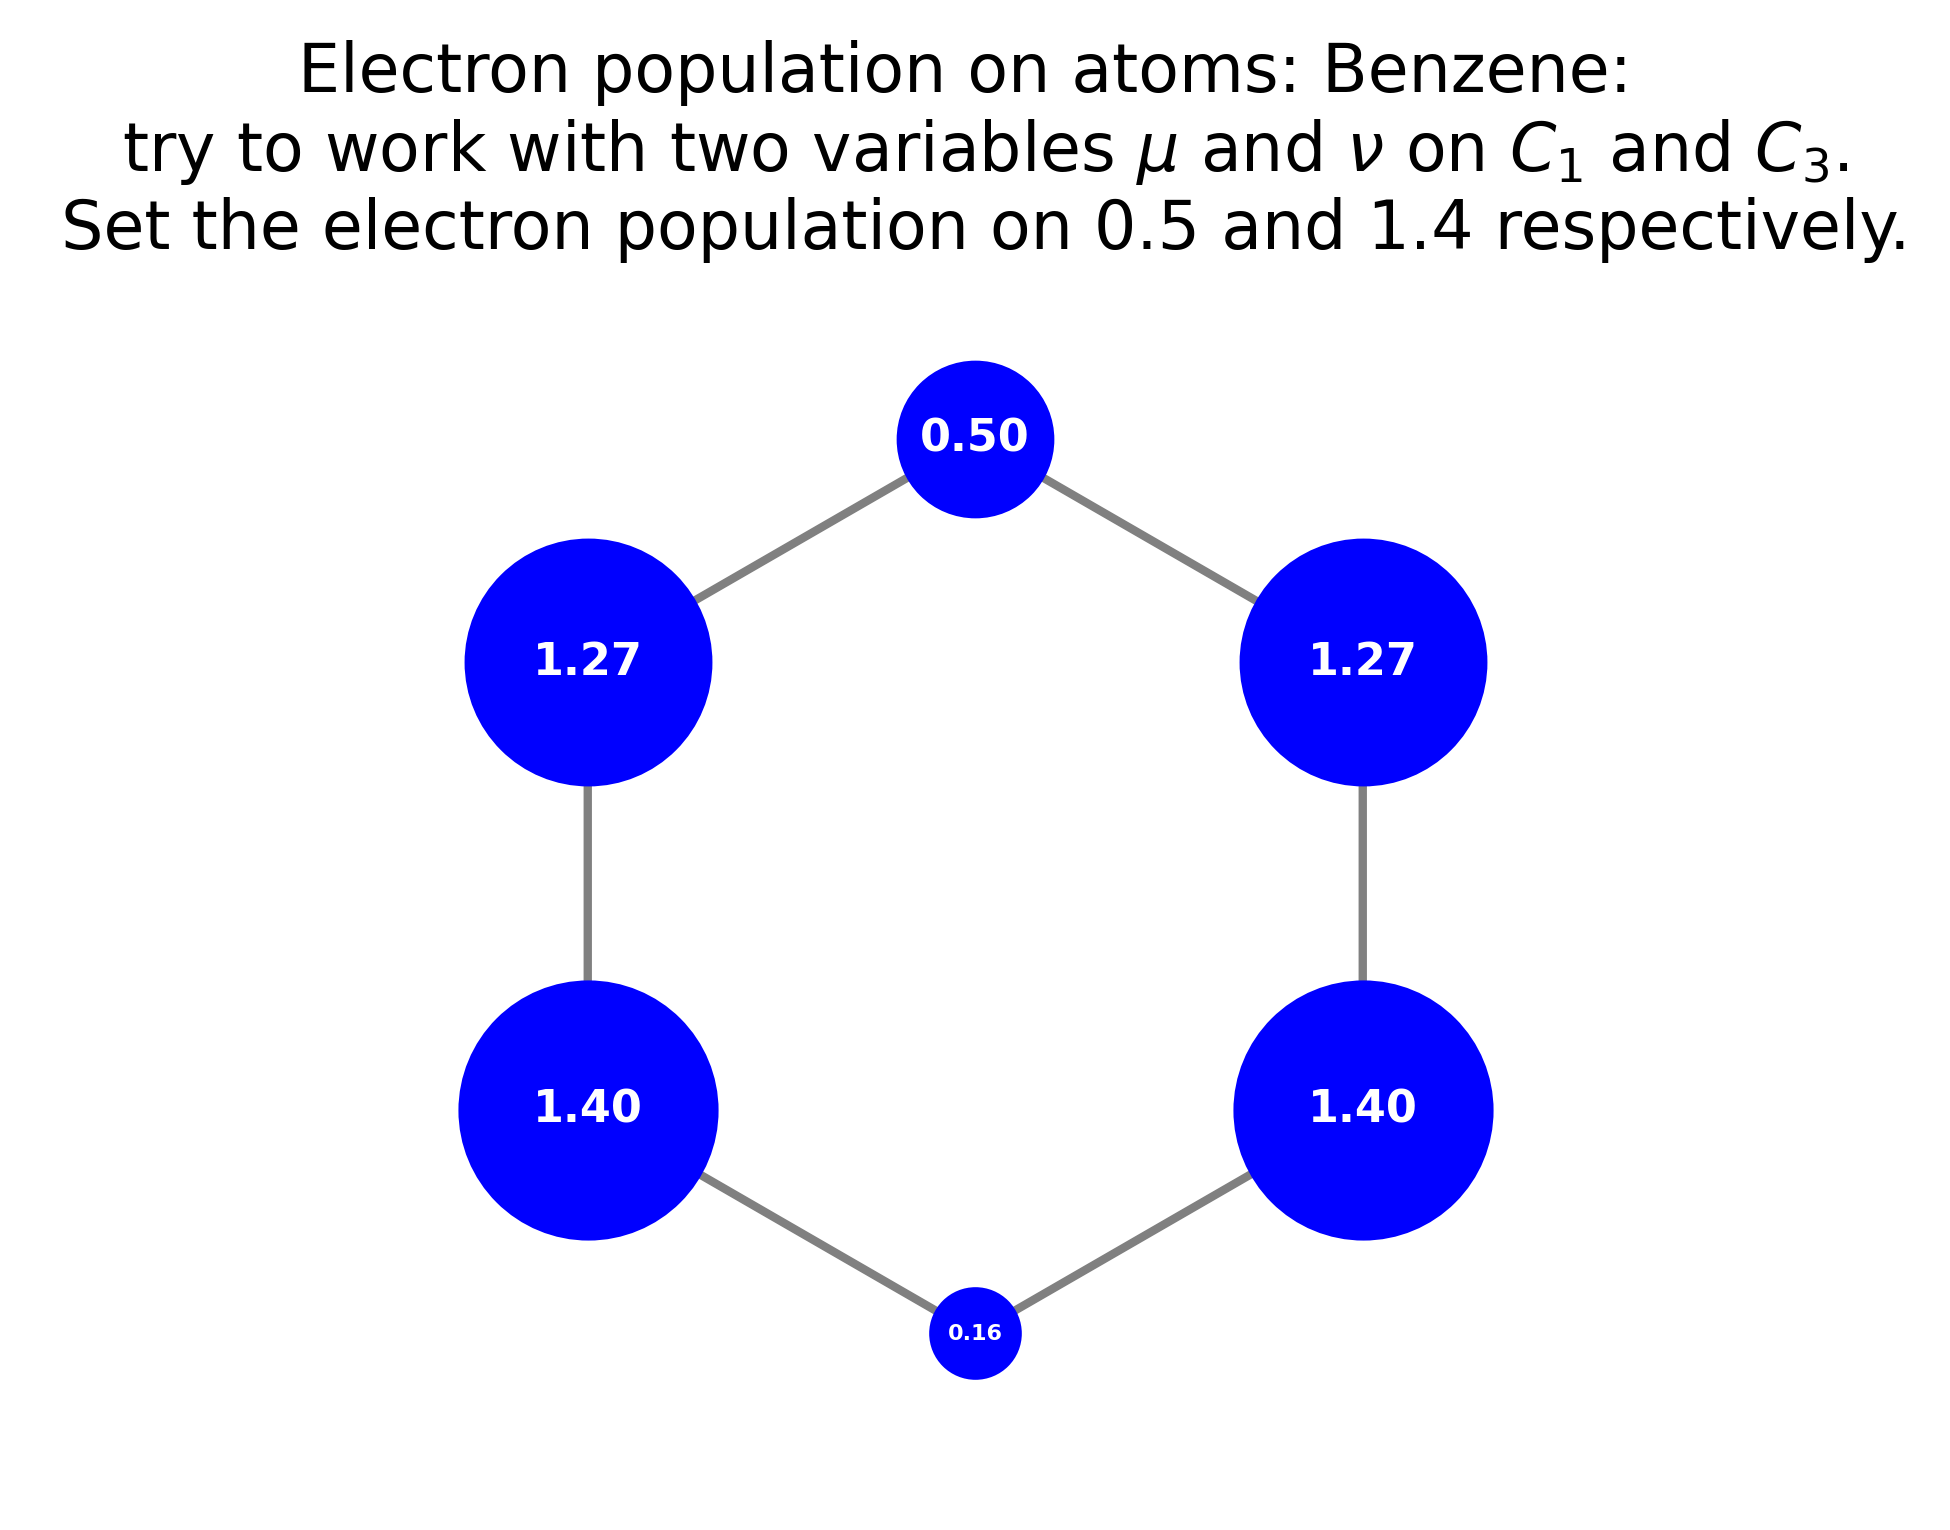

In [ ]:
mu, nu = optimale_parameters
benzene.huckel_matrix = H + mu * one_electron_operator + nu * another_operator 
benzene.solve_huckel_matrix()
eigenvectors = benzene.eigenvectors
D_huckel = pts.making_D(eigenvectors, 6)
pts.plotting_of_D_atoms(6, coordinates, extra_bounds, D_huckel, 'Benzene', '\n try to work with two variables $\\mu$ and $\\nu$ on $C_1$ and $C_3$.\n Set the electron population on 0.5 and 1.4 respectively.')